# Introduction to Autoencoders

These exercises will take you through implementing your own autoencoder using [Keras](https://keras.io/).

Keras is a high-level SDK built on top of Tensorflow to make it very simple to build neural networks from scratch.

Let's start off by just importing Keras and some useful subpackages.

In [ ]:
import keras
import keras.activations
import keras.datasets.mnist
import keras.layers
import keras.metrics

import numpy as np
import matplotlib.pyplot as plt

The dataset we'll be working on is MNIST, a large collection of handwritten digits. We have intentionally chosen an image dataset, allowing us to visualize the input and output of our model, since autoencoders are all about reconstructing.

The dataset is available in Keras. First step is of course loading the data. Take a look at the shapes and contents of the variables.

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

We can plot some of our data samples to see what we're working with.

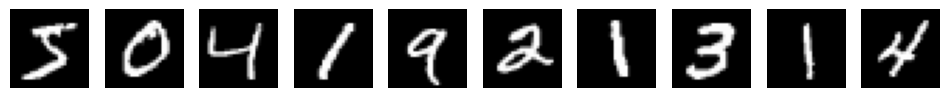

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(12, 4))

for (ax, sample) in zip(axes, X_train):
    ax.imshow(sample, cmap='gray')
    ax.set_axis_off()

plt.show()

Since we're focusing on anomaly detection, you should pick one of the digits and only train on that specific digit. The goal is for the autoencoder to accurately reconstruct that specific digit, while not being able to reconstruct the remaining digits.

In [ ]:
# Filter training data 

We'll start by using the simplest form of layers, namely fully connected (also called dense) layers.
Note that the expected input shape for `keras.layers.Dense` is one-dimensional.

In [ ]:
# Change the shape of the input data

Activation functions are an important part of neural networks. As a rule of thumb, you can use `keras.activations.relu` for hidden layers. For the output layer however, the activation function is decided by the range you want your output data to have. Use `keras.activations.tanh` for the range `[-1, 1]`  and use `keras.activations.sigmoid` for the range `[0, 1]`. We can plot the different activation functions to see how they behave.

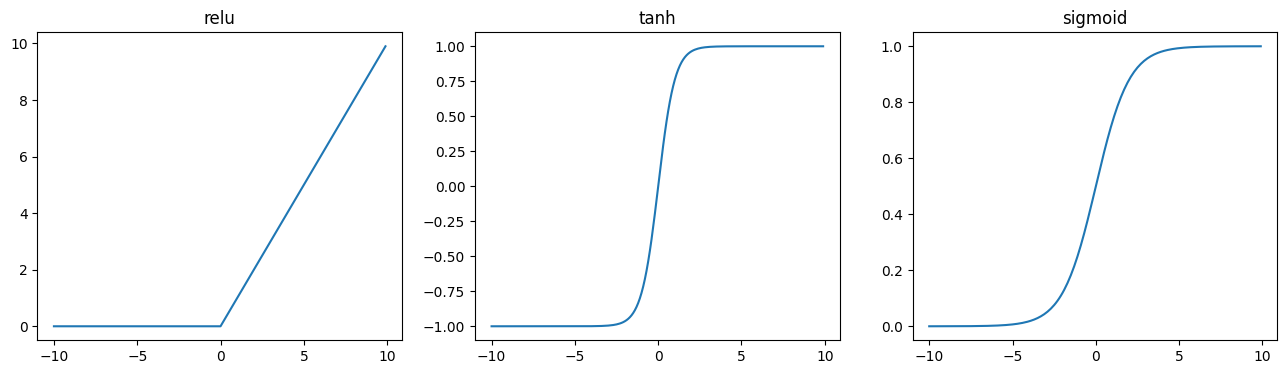

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

x = np.arange(-10, 10, 0.1)
axes[0].plot(x, keras.activations.relu(x)); axes[0].set_title('relu')
axes[1].plot(x, keras.activations.tanh(x)); axes[1].set_title('tanh')
axes[2].plot(x, keras.activations.sigmoid(x)); axes[2].set_title('sigmoid')

plt.show()

In [6]:
# Change the range of the input data

Now we need to define the model architecture. The whole idea behind the autoencoder is to create a bottleneck with our layers. This is achieved by varying the number of units in each layer. Remember that the input and output layer should have the same number of units.

What we're using here is Keras' [Sequential](https://keras.io/guides/sequential_model/) API, which basically means that the output of one layer is the input to the next. If you want a more customized architecture, you can also define your own layers. The only time you cannot use the Sequential API, is if you want to combine multiple layers or reuse the output from one of the layers.

In [50]:
class MyModel(keras.Sequential):
    def __init__(self, name=None):
        super().__init__(
            layers=[
                # Add layers here
                keras.layers.InputLayer(input_shape=(42,)),         # <-- Example input layer
                keras.layers.Dense(units=42, activation='relu'),    # <-- Example dense layer
            ],
            name=name,
        )

Create an instance of your model.

In [51]:
model = MyModel()

We can display the number of parameters in the model using the summary function. Note that the input layer is not actually a real layer with parameters, thus omitted from the summary.

In [52]:
model.summary()

Model: "my_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 42)                1806      
                                                                 
Total params: 1,806
Trainable params: 1,806
Non-trainable params: 0
_________________________________________________________________


Before we can train our model, we need to specify which [optimizer](https://keras.io/api/optimizers/) to use, and also which [loss function](https://keras.io/api/losses/) to optimize. [Adam](https://keras.io/api/optimizers/adam/) is one of the most popular optimizers, providing good results for a wide range of problems. In terms of loss function, it makes sense to use mean squared error for comparing the difference between two images. Feel free to experiment with other options.

In [ ]:
model.compile(optimizer='adam', loss='mse')

Now it's time to train the model. The great thing about autoencoders is that you don't need any labels for your input data. It is completely unsupervised, and you just want your output to be identical to your input.

In [ ]:
history = model.fit(x=X_train, y=X_train, epochs=20)

You can plot the loss from your training to verify that the model's weights have converged.

In [ ]:
plt.plot(history.history['loss'])

If the loss doesn't decrease while training, there must be something wrong.

There are a couple of things you can check:
- Does the input and output data have the same range?
- Is the model underfitting? A too tight bottleneck prevents the model from learning anything.


Once the model is trained, we can try to reconstruct our testing data.

In [ ]:
X_pred = model.predict(X_test)

You can adapt the snippet from the top to plot your testing data and your reconstructions. You may have to do some reshaping again if your data is one-dimensional.

In [ ]:
# Plot reconstructions and compare them with the true data

To go from a reconstructed image to a reconstruction score, we simply compute the difference between true and reconstructed images, square the difference and average per sample (basically the MSE).

In [ ]:
# Compute reconstruction scores

How well does your model perform? Is it able to reconstruct the digit it has trained on?

You can use the methods in `keras.metrics` to evaluate the performance. You may have to decide on a threshold to turn your reconstruction scores into binary True/False predictions to use some of the metrics.

In [ ]:
# Evaluate model performance

Now that you have your first results, there are a couple of things you can try out (in no particular order):

- 
    Experiment with the number of layers and units. Doing so alters the *complexity* of your model. A complex model has many trainable parameters and is able to reconstruct more accurately. A simple model is the opposite with few trainable parameters and is very limited in its reconstructions. How do you decide the perfect amount of complexity? Try to get the model to overfit and underfit, and see the effect on your reconstructions.

-   
    Try to create a convolutional autoencoder by using `keras.layers.Conv2D` and `keras.layers.Conv2DTranspose` layers. Set `strides=(2, 2)` to create the bottleneck. The convolutional layer will downsample the image, and the transpose convolutional layer will upsample it. Note that convolutional layers expects three-dimensional data of `(width, height, channels)`. RGB images would have three channels, but our grayscale images only has one.

    A convolutional autoencoder can also have dense layers in the bottleneck. Try it out. You have to use `keras.layers.Flatten` to go from 3D to 1D and `keras.layers.Reshape` to go back from 1D to 3D.

-
    By having a bottleneck in the autoencoder, we're forcing the model to learn a compact representation of our training data. You can think of the encoder as compressing the input data, and the decoder as decompressing it. The only caveat is that the decoder is only able to decompress specific data.

    Let's have a look at the compact representation of our digits. To do so, we need to split our model into two separate models. One for the encoder and one for the decoder. Use the Sequential API to define each of the models, and the class below to combine them into a single model. By subclassing `keras.Model` we can define our own `call` function.

    After you have trained the combined model, you can use only the encoder to extract the compact representation. How does the representation differ for digits we have trained on and digits we haven't trained on?

In [ ]:
# Combining separate encoder and decoder models
class MyModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.encoder = None
        self.decoder = None
    
    def call(self, X):
        return self.decoder(self.encoder(X))